In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from cmocean import cm
from xhistogram.xarray import histogram
import xskillscore as xs

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(14*5)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.220:43566 Dashboard: http://10.148.0.220:8787/status,Cluster Workers: 42 Cores: 42 Memory: 670.74 GiB


_________
# 1. Read dataset



In [5]:
out_dir_store = '/home1/scratch/xyu/KE/parameter/'
D = [xr.open_zarr(out_dir_store+'Fs_filter_d%02d.zarr'%(depth)) for depth in range(52)]
Fs = xr.concat(D, dim='depth')
Fs = Fs.Fs_single
Fs

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


____________
## KE forward cascade and frontogenesis

In [6]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/cg_butter/'
D = [xr.open_zarr(out_dir_store+'PI_cg_1d_d%02d.zarr'%(depth)) for depth in range(52)]

PI_cg_1d = xr.concat(D, dim='depth')
PI_cg_1d = PI_cg_1d.PI_cg_1d_single
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime
time_day = iters_to_date(np.arange(9415))
PI_cg_1d = PI_cg_1d.assign_coords(time=time_day) 

print(PI_cg_1d)
print('\n data size: %.1f GB' %(PI_cg_1d.nbytes / 1e9))

<xarray.DataArray 'PI_cg_1d_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00

 data size: 69.7 GB


In [7]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/cg_butter/'
D = [xr.open_zarr(out_dir_store+'PI_cg_5d_d%02d.zarr'%(depth)) for depth in range(52)]

PI_cg_5d = xr.concat(D, dim='depth')
PI_cg_5d = PI_cg_5d.PI_cg_5d_single
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime
time_day = iters_to_date(np.arange(9415))
PI_cg_5d = PI_cg_5d.assign_coords(time=time_day) 
print(PI_cg_5d)
print('\n data size: %.1f GB' %(PI_cg_5d.nbytes / 1e9))

<xarray.DataArray 'PI_cg_5d_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00

 data size: 69.7 GB


In [8]:
ds = xr.merge([Fs,PI_cg_1d,PI_cg_5d])
ds

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [9]:
#spring = ds.isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(16,39)).sel(time=slice('2012-03-01T00:00:00','2012-04-01T00:00:00'))
spring = ds.isel(lat=slice(2,-2),lon=slice(2,-2),depth=0).sel(time=slice('2012-03-01T00:00:00','2012-06-01T00:00:00'))
spring.load()
print(spring)
print('\n data size: %.1f GB' %(spring.nbytes / 1e9))

<xarray.Dataset>
Dimensions:          (lat: 197, lon: 173, time: 2209)
Coordinates:
    depth            float64 0.5
  * lat              (lat) float64 47.43 47.44 47.46 47.47 ... 49.94 49.95 49.96
  * lon              (lon) float64 -17.99 -17.97 -17.95 ... -14.45 -14.43 -14.41
  * time             (time) datetime64[ns] 2012-03-01 ... 2012-06-01
Data variables:
    Fs_single        (time, lat, lon) float32 1.558e-20 1.223e-20 ... -1.525e-21
    PI_cg_1d_single  (time, lat, lon) float32 -1.885e-08 ... 3.146e-08
    PI_cg_5d_single  (time, lat, lon) float32 4.881e-08 3.574e-08 ... 5.446e-09

 data size: 0.9 GB


In [10]:
x_bins = np.arange(-26, -17, 0.25)
y_bins = np.arange(-15, -5, 0.15)

hTS_1d = histogram(np.log10(spring.Fs_single), 
                   np.log10(spring.PI_cg_1d_single), 
                   bins=[x_bins, y_bins],
                   block_size=None
                  )

hTS_5d = histogram(np.log10(spring.Fs_single), 
                   np.log10(spring.PI_cg_5d_single), 
                   bins=[x_bins, y_bins],
                   block_size=None
                  )

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


In [11]:
x_bins = np.arange(-26, -17, 0.25)
y_bins = np.arange(-15, -5, 0.15)

hTS_1d_negative = histogram(np.log10(np.abs(spring.Fs_single.where(spring.Fs_single<0))), 
                            np.log10(spring.PI_cg_1d_single.where(spring.Fs_single<0)), 
                            bins=[x_bins, y_bins],
                            block_size=None
                           )

hTS_5d_negative = histogram(np.log10(spring.Fs_single), 
                            np.log10(spring.PI_cg_5d_single), 
                            bins=[x_bins, y_bins],
                            block_size=None
                           )

In [12]:
x_bins = np.arange(-26, -17, 0.25)
y_bins = np.arange(-15, -5, 0.15)

hTS_1d_all = histogram(np.log10(np.abs(spring.Fs_single)), 
                       np.log10(spring.PI_cg_1d_single), 
                       bins=[x_bins, y_bins],
                       block_size=None
                      )

hTS_5d_all = histogram(np.log10(np.abs(spring.Fs_single)), 
                       np.log10(spring.PI_cg_5d_single), 
                       bins=[x_bins, y_bins],
                       block_size=None
                      )

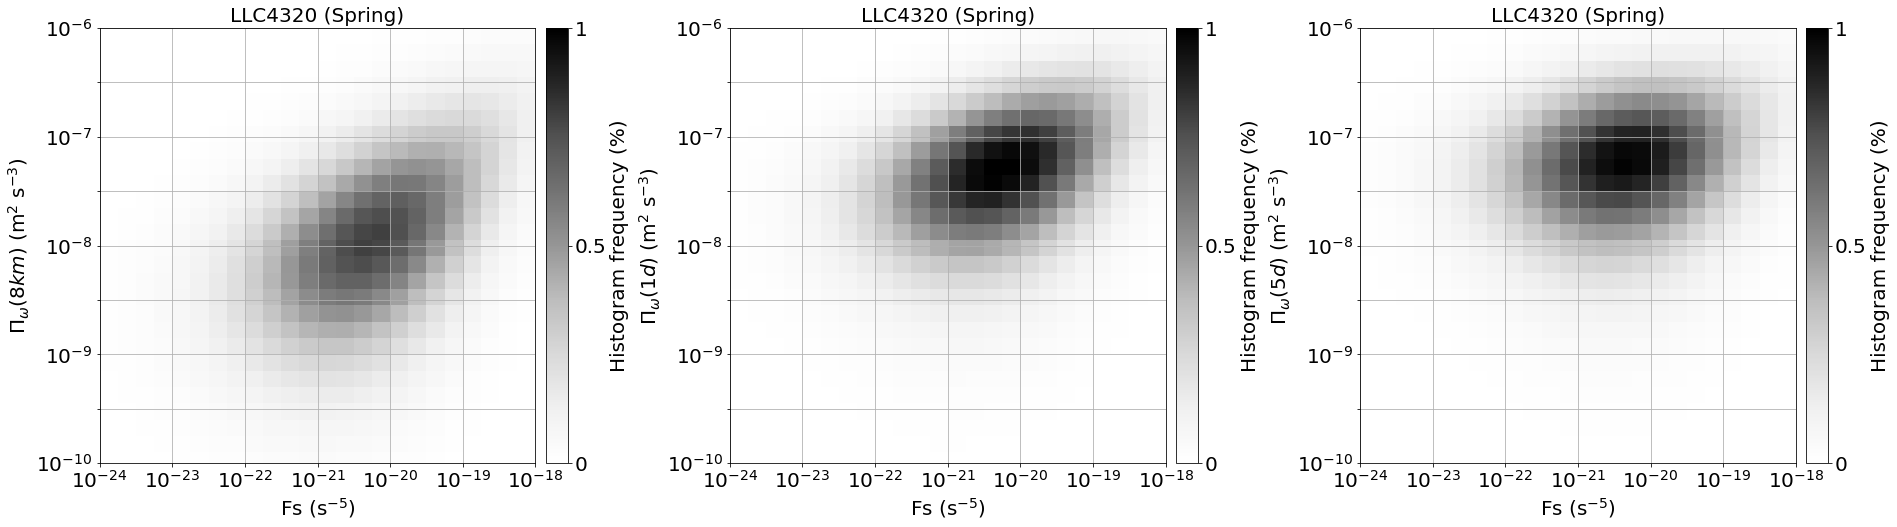

In [46]:
plt.rc('font', size=20) 
font_size = 20
font_title = 20

fig = plt.figure(figsize=(32,8))

ax = plt.subplot(131)
cax = (hTS_8km/hTS_8km.sum()).plot(x='Fs_single_bin',y='PI_cg_single_bin',cmap='Greys',vmin=0,vmax=0.01, add_colorbar = False) 
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[0, 0.005, 0.01], pad=0.02)
cbar.set_ticklabels(['0','0.5', '1'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Histogram frequency (%)', fontsize=font_size)
ax.grid()
ax.set_xlim([-24,-18])
ax.set_ylim([-10,-6])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([-10,-9.5,-9,-8.5,-8,-7.5,-7,-6.5,-6])
ax.set_yticklabels(['10$^{-10}$','','10$^{-9}$','','10$^{-8}$','','10$^{-7}$','','10$^{-6}$'], ha='right')
ax.set_xticks([-24,-23,-22,-21,-20,-19,-18])
ax.set_xticklabels(['10$^{-24}$','10$^{-23}$','10$^{-22}$','10$^{-21}$','10$^{-20}$','10$^{-19}$','10$^{-18}$'], ha='center')
ax.set_ylabel('$\Pi_{\omega}(8km)$ (m$^2$ s$^{-3}$)', fontsize=font_size)
ax.set_xlabel('Fs (s$^{-5}$)', fontsize=font_size)
ax.set_title('LLC4320 (Spring)',fontsize=font_size)

ax = plt.subplot(132)
cax = (hTS_1d/hTS_1d.sum()).plot(x='Fs_single_bin',y='PI_cg_1d_single_bin',cmap='Greys',vmin=0,vmax=0.01, add_colorbar = False) 
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[0, 0.005, 0.01], pad=0.02)
cbar.set_ticklabels(['0','0.5', '1'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Histogram frequency (%)', fontsize=font_size)
ax.grid()
ax.set_xlim([-24,-18])
ax.set_ylim([-10,-6])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([-10,-9.5,-9,-8.5,-8,-7.5,-7,-6.5,-6])
ax.set_yticklabels(['10$^{-10}$','','10$^{-9}$','','10$^{-8}$','','10$^{-7}$','','10$^{-6}$'], ha='right')
ax.set_xticks([-24,-23,-22,-21,-20,-19,-18])
ax.set_xticklabels(['10$^{-24}$','10$^{-23}$','10$^{-22}$','10$^{-21}$','10$^{-20}$','10$^{-19}$','10$^{-18}$'], ha='center')
ax.set_ylabel('$\Pi_{\omega}(1d)$ (m$^2$ s$^{-3}$)', fontsize=font_size)
ax.set_xlabel('Fs (s$^{-5}$)', fontsize=font_size)
ax.set_title('LLC4320 (Spring)',fontsize=font_size)

ax = plt.subplot(133)
cax = (hTS_5d/hTS_5d.sum()).plot(x='Fs_single_bin',y='PI_cg_5d_single_bin',cmap='Greys',vmin=0,vmax=0.01, add_colorbar = False) 
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[0, 0.005, 0.01], pad=0.02)
cbar.set_ticklabels(['0','0.5', '1'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Histogram frequency (%)', fontsize=font_size)
ax.grid()
ax.set_xlim([-24,-18])
ax.set_ylim([-10,-6])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([-10,-9.5,-9,-8.5,-8,-7.5,-7,-6.5,-6])
ax.set_yticklabels(['10$^{-10}$','','10$^{-9}$','','10$^{-8}$','','10$^{-7}$','','10$^{-6}$'], ha='right')
ax.set_xticks([-24,-23,-22,-21,-20,-19,-18])
ax.set_xticklabels(['10$^{-24}$','10$^{-23}$','10$^{-22}$','10$^{-21}$','10$^{-20}$','10$^{-19}$','10$^{-18}$'], ha='center')
ax.set_ylabel('$\Pi_{\omega}(5d)$ (m$^2$ s$^{-3}$)', fontsize=font_size)
ax.set_xlabel('Fs (s$^{-5}$)', fontsize=font_size)
ax.set_title('LLC4320 (Spring)',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/KE_LLC4320/Diagnostics/Figures/Save_figs/Pi_cg_Fs_spring_0423.png')

___________

## Correlation R and p value

## 1d

In [19]:
sub=1
r = xs.pearson_r(np.log10(spring.Fs_single.where(spring.Fs_single>0).isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 1))),
                 np.log10(spring.PI_cg_1d_single.where(spring.Fs_single>0).isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 1))),
                 skipna=True
                )
r

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


<xarray.DataArray ()>
array(0.3375206)
Coordinates:
    depth    float64 0.5

In [20]:
sub=1
p = xs.pearson_r_eff_p_value(np.log10(spring.Fs_single.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 1))),
                             np.log10(spring.PI_cg_1d_single.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 1))),
                             dim=['time'],
                             skipna=True
                            )
p.mean(['lat','lon'])

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


<xarray.DataArray ()>
array(0.03287555)
Coordinates:
    depth    float64 0.5

In [21]:
sub=1
r = xs.pearson_r(np.log10(np.abs(spring.Fs_single).isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 1))),
                 np.log10(spring.PI_cg_1d_single.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 1))),
                 skipna=True
                )
r

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


<xarray.DataArray ()>
array(0.31173307)
Coordinates:
    depth    float64 0.5

In [12]:
sub=1
p = xs.pearson_r_eff_p_value(np.log10(np.abs(spring.Fs_single).isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 1))),
                             np.log10(spring.PI_cg_1d_single.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 1))),
                             dim=['time'],
                             skipna=True
                            )
p.mean(['lat','lon'])

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


<xarray.DataArray ()>
array(0.01169281)
Coordinates:
    depth    float64 0.5

# 5d

In [16]:
sub=1
r = xs.pearson_r(np.log10(spring.Fs_single.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 1))),
                 np.log10(spring.PI_cg_5d_single.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 1))),
                 skipna=True
                )
r

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


<xarray.DataArray ()>
array(0.19285452)
Coordinates:
    depth    float64 0.5

In [22]:
sub=1
p = xs.pearson_r_eff_p_value(np.log10(spring.Fs_single.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 1))),
                             np.log10(spring.PI_cg_5d_single.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 1))),
                             dim=['time'],
                             skipna=True
                            )
p.mean(['lat','lon'])

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


<xarray.DataArray ()>
array(0.43344427)
Coordinates:
    depth    float64 0.5

In [13]:
sub=1
r = xs.pearson_r(np.log10(np.abs(spring.Fs_single).isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 1))),
                 np.log10(spring.PI_cg_5d_single.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 1))),
                 skipna=True
                )
r

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


<xarray.DataArray ()>
array(0.18099366)
Coordinates:
    depth    float64 0.5

In [14]:
sub=1
p = xs.pearson_r_eff_p_value(np.log10(np.abs(spring.Fs_single).isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 1))),
                             np.log10(spring.PI_cg_5d_single.isel(lat=slice(0 ,None, sub),lon=slice(0 ,None, sub),time=slice(0 ,None, 1))),
                             dim=['time'],
                             skipna=True
                            )
p.mean(['lat','lon'])

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


<xarray.DataArray ()>
array(0.31495021)
Coordinates:
    depth    float64 0.5

# Together

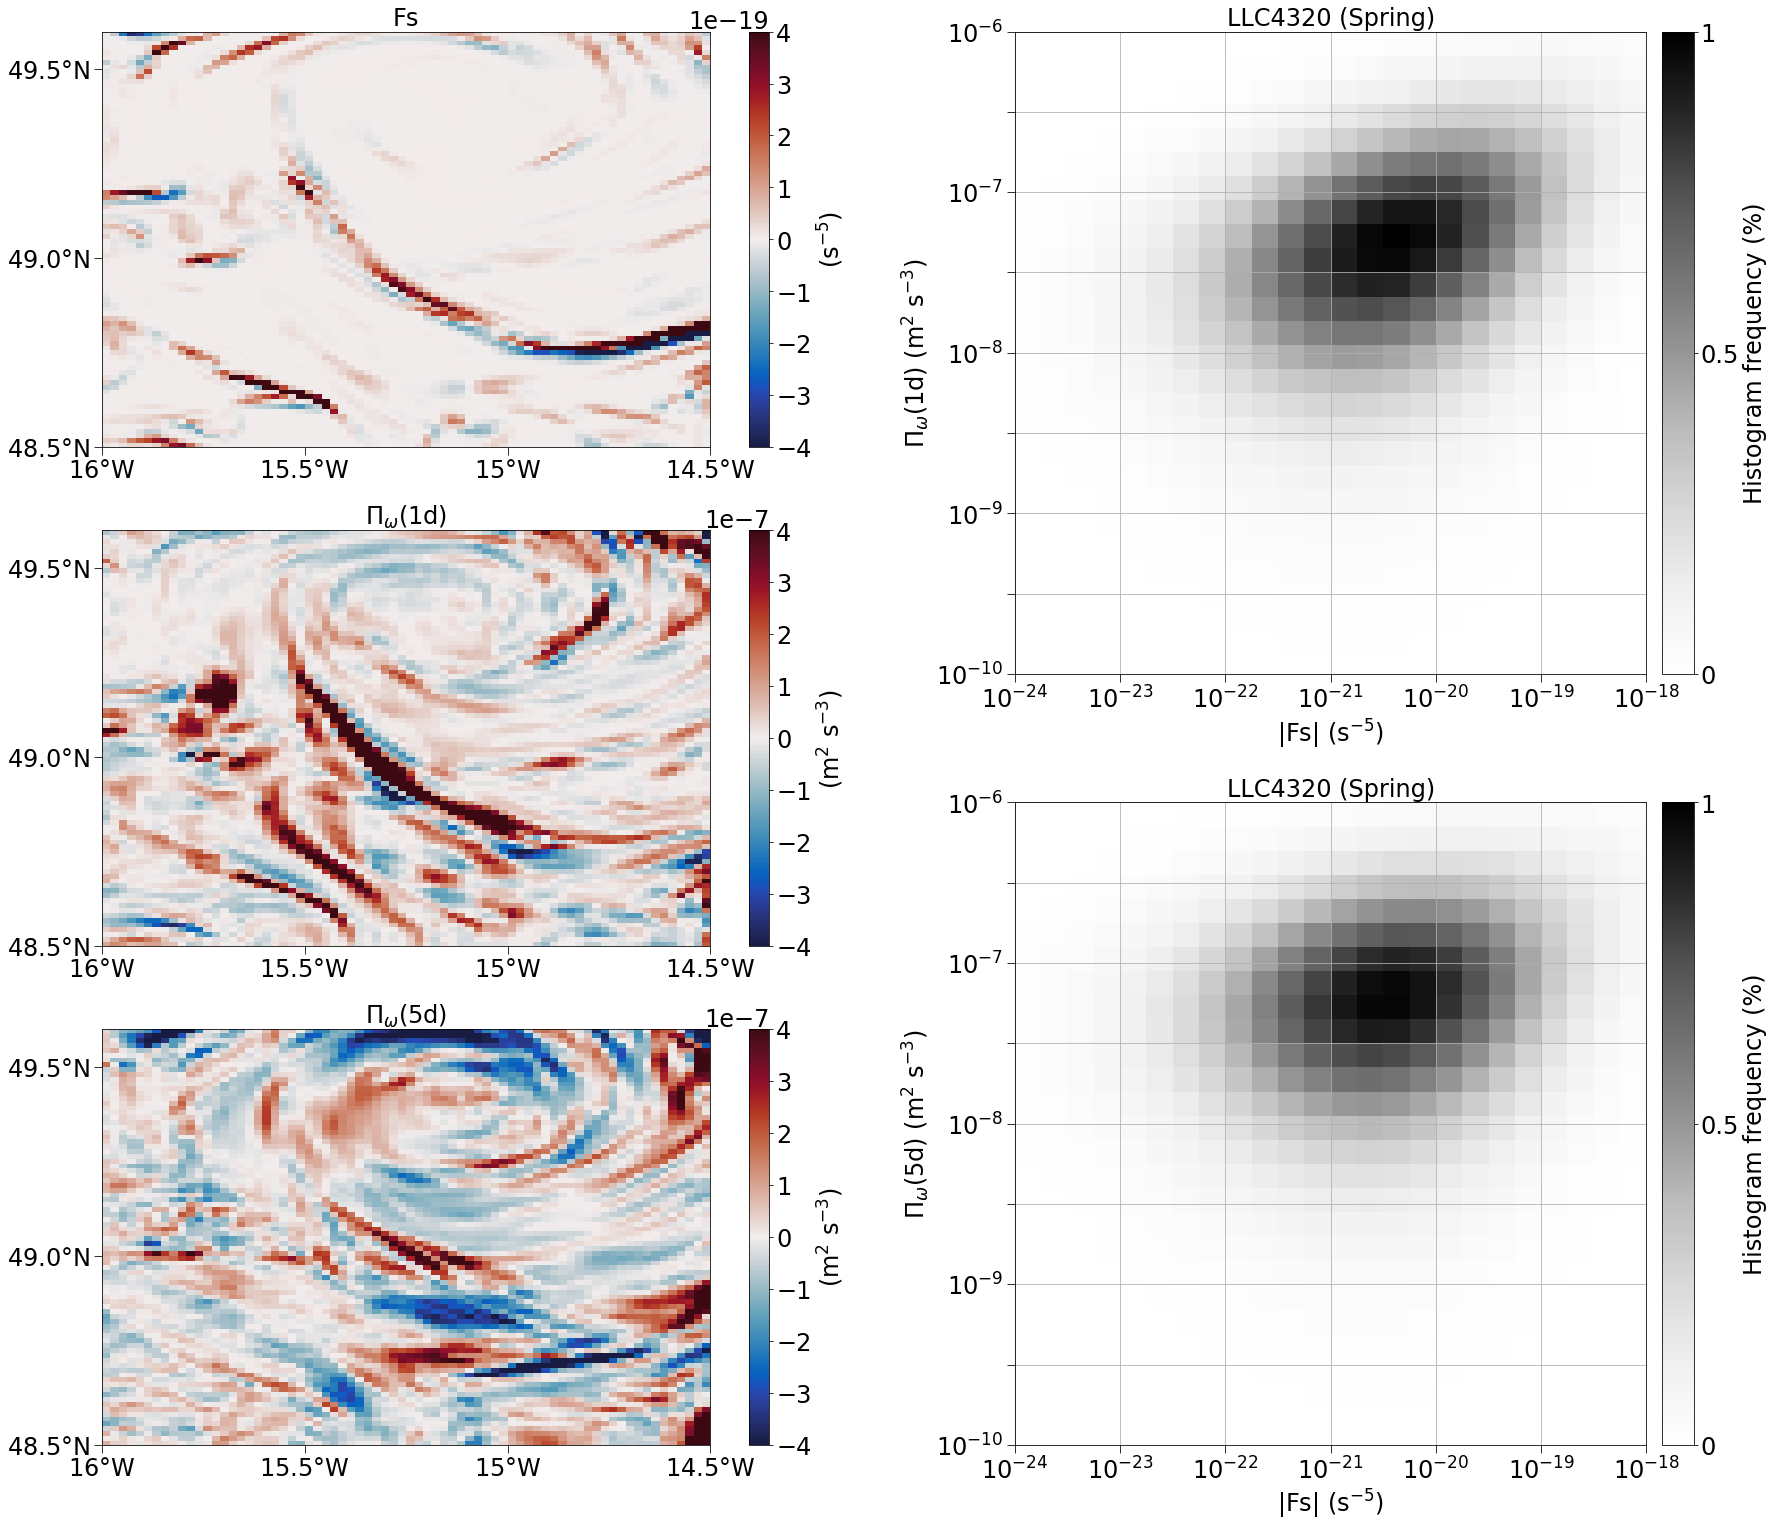

In [26]:
plt.rc('font', size=24) 
font_size=24

Time = '2012-03-07T00:00:00'

fig, ax = plt.subplots(figsize=(30,26))


ax = plt.subplot(321)
cax = Fs.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=-4e-19, vmax=4e-19, cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(s$^{-5}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Fs',fontsize=font_size)
ax.set_xlim([-16.0, -14.5])
ax.set_ylim([48.5, 49.6])
ax.set_xticks([-16,-15.5,-15,-14.5])
ax.set_xticklabels(['$16\degree$W','$15.5\degree$W','$15\degree$W','$14.5\degree$W'], ha='center')
ax.set_yticks([48.5,49.0,49.5])
ax.set_yticklabels(['$48.5\degree$N','$49.0\degree$N','$49.5\degree$N'])
ax.tick_params(direction='out', length=8)

ax = plt.subplot(323)
cax = PI_cg_1d.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-4e-7,vmax=4e-7, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{2}$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{\omega}$(1d)',fontsize=font_size)
ax.set_xlim([-16.0, -14.5])
ax.set_ylim([48.5, 49.6])
ax.set_xticks([-16,-15.5,-15,-14.5])
ax.set_xticklabels(['$16\degree$W','$15.5\degree$W','$15\degree$W','$14.5\degree$W'], ha='center')
ax.set_yticks([48.5,49.0,49.5])
ax.set_yticklabels(['$48.5\degree$N','$49.0\degree$N','$49.5\degree$N'])
ax.tick_params(direction='out', length=8)

ax = plt.subplot(325)
cax = PI_cg_5d.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-4e-7,vmax=4e-7, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{2}$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{\omega}$(5d)',fontsize=font_size)
ax.set_xlim([-16.0, -14.5])
ax.set_ylim([48.5, 49.6])
ax.set_xticks([-16,-15.5,-15,-14.5])
ax.set_xticklabels(['$16\degree$W','$15.5\degree$W','$15\degree$W','$14.5\degree$W'], ha='center')
ax.set_yticks([48.5,49.0,49.5])
ax.set_yticklabels(['$48.5\degree$N','$49.0\degree$N','$49.5\degree$N'])
ax.tick_params(direction='out', length=8)

ax = plt.subplot(222)
cax = (hTS_1d_all/hTS_1d_all.sum()).plot(x='Fs_single_bin',y='PI_cg_1d_single_bin',cmap='Greys',vmin=0,vmax=0.01, add_colorbar = False) 
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[0, 0.005, 0.01], pad=0.02)
cbar.set_ticklabels(['0','0.5', '1'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Histogram frequency (%)', fontsize=font_size)
ax.grid()
ax.set_xlim([-24,-18])
ax.set_ylim([-10,-6])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([-10,-9.5,-9,-8.5,-8,-7.5,-7,-6.5,-6])
ax.set_yticklabels(['10$^{-10}$','','10$^{-9}$','','10$^{-8}$','','10$^{-7}$','','10$^{-6}$'], ha='right')
ax.set_xticks([-24,-23,-22,-21,-20,-19,-18])
ax.set_xticklabels(['10$^{-24}$','10$^{-23}$','10$^{-22}$','10$^{-21}$','10$^{-20}$','10$^{-19}$','10$^{-18}$'], ha='center')
ax.set_ylabel('$\Pi_{\omega}$(1d) (m$^2$ s$^{-3}$)', fontsize=font_size)
ax.set_xlabel('$|$Fs$|$ (s$^{-5}$)', fontsize=font_size)
ax.set_title('LLC4320 (Spring)',fontsize=font_size)
ax.tick_params(direction='out', length=8)

ax = plt.subplot(224)
cax = (hTS_5d_all/hTS_5d_all.sum()).plot(x='Fs_single_bin',y='PI_cg_5d_single_bin',cmap='Greys',vmin=0,vmax=0.01, add_colorbar = False) 
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[0, 0.005, 0.01], pad=0.02)
cbar.set_ticklabels(['0','0.5', '1'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Histogram frequency (%)', fontsize=font_size)
ax.grid()
ax.set_xlim([-24,-18])
ax.set_ylim([-10,-6])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([-10,-9.5,-9,-8.5,-8,-7.5,-7,-6.5,-6])
ax.set_yticklabels(['10$^{-10}$','','10$^{-9}$','','10$^{-8}$','','10$^{-7}$','','10$^{-6}$'], ha='right')
ax.set_xticks([-24,-23,-22,-21,-20,-19,-18])
ax.set_xticklabels(['10$^{-24}$','10$^{-23}$','10$^{-22}$','10$^{-21}$','10$^{-20}$','10$^{-19}$','10$^{-18}$'], ha='center')
ax.set_ylabel('$\Pi_{\omega}$(5d) (m$^2$ s$^{-3}$)', fontsize=font_size)
ax.set_xlabel('$|$Fs$|$ (s$^{-5}$)', fontsize=font_size)
ax.set_title('LLC4320 (Spring)',fontsize=font_size)
ax.tick_params(direction='out', length=8)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/KE_LLC4320/Diagnostics/Figures/Save_figs/Fs_Pi_omega_snapshot_0503.png')

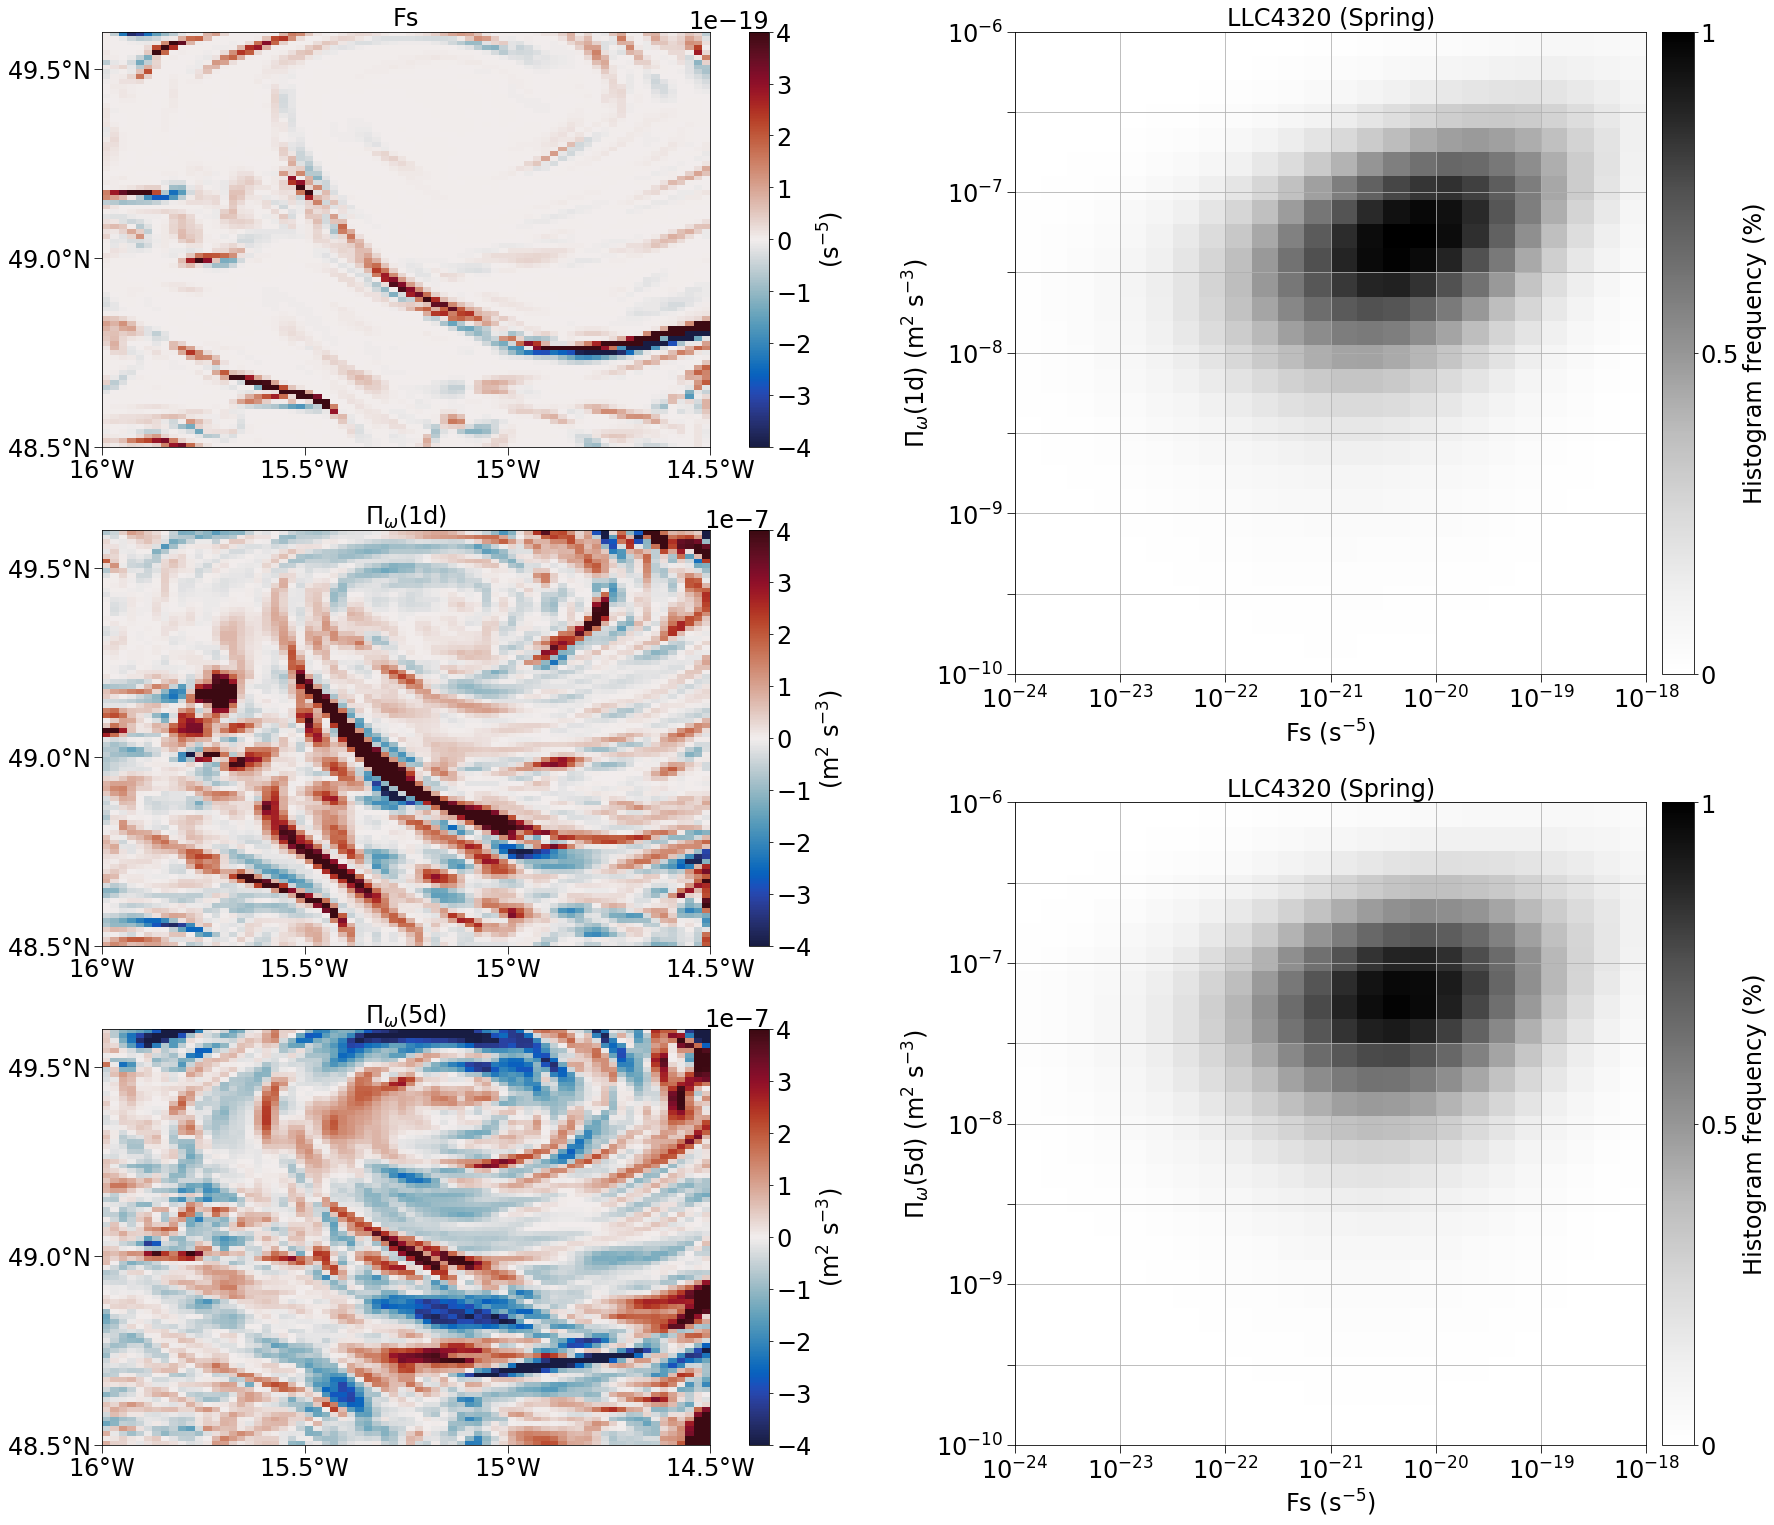

In [16]:
plt.rc('font', size=24) 
font_size=24

Time = '2012-03-07T00:00:00'

fig, ax = plt.subplots(figsize=(30,26))


ax = plt.subplot(321)
cax = Fs.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=-4e-19, vmax=4e-19, cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(s$^{-5}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Fs',fontsize=font_size)
ax.set_xlim([-16.0, -14.5])
ax.set_ylim([48.5, 49.6])
ax.set_xticks([-16,-15.5,-15,-14.5])
ax.set_xticklabels(['$16\degree$W','$15.5\degree$W','$15\degree$W','$14.5\degree$W'], ha='center')
ax.set_yticks([48.5,49.0,49.5])
ax.set_yticklabels(['$48.5\degree$N','$49.0\degree$N','$49.5\degree$N'])
ax.tick_params(direction='out', length=8)

ax = plt.subplot(323)
cax = PI_cg_1d.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-4e-7,vmax=4e-7, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{2}$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{\omega}$(1d)',fontsize=font_size)
ax.set_xlim([-16.0, -14.5])
ax.set_ylim([48.5, 49.6])
ax.set_xticks([-16,-15.5,-15,-14.5])
ax.set_xticklabels(['$16\degree$W','$15.5\degree$W','$15\degree$W','$14.5\degree$W'], ha='center')
ax.set_yticks([48.5,49.0,49.5])
ax.set_yticklabels(['$48.5\degree$N','$49.0\degree$N','$49.5\degree$N'])
ax.tick_params(direction='out', length=8)

ax = plt.subplot(325)
cax = PI_cg_5d.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-4e-7,vmax=4e-7, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{2}$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{\omega}$(5d)',fontsize=font_size)
ax.set_xlim([-16.0, -14.5])
ax.set_ylim([48.5, 49.6])
ax.set_xticks([-16,-15.5,-15,-14.5])
ax.set_xticklabels(['$16\degree$W','$15.5\degree$W','$15\degree$W','$14.5\degree$W'], ha='center')
ax.set_yticks([48.5,49.0,49.5])
ax.set_yticklabels(['$48.5\degree$N','$49.0\degree$N','$49.5\degree$N'])
ax.tick_params(direction='out', length=8)

ax = plt.subplot(222)
cax = (hTS_1d/hTS_1d.sum()).plot(x='Fs_single_bin',y='PI_cg_1d_single_bin',cmap='Greys',vmin=0,vmax=0.01, add_colorbar = False) 
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[0, 0.005, 0.01], pad=0.02)
cbar.set_ticklabels(['0','0.5', '1'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Histogram frequency (%)', fontsize=font_size)
ax.grid()
ax.set_xlim([-24,-18])
ax.set_ylim([-10,-6])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([-10,-9.5,-9,-8.5,-8,-7.5,-7,-6.5,-6])
ax.set_yticklabels(['10$^{-10}$','','10$^{-9}$','','10$^{-8}$','','10$^{-7}$','','10$^{-6}$'], ha='right')
ax.set_xticks([-24,-23,-22,-21,-20,-19,-18])
ax.set_xticklabels(['10$^{-24}$','10$^{-23}$','10$^{-22}$','10$^{-21}$','10$^{-20}$','10$^{-19}$','10$^{-18}$'], ha='center')
ax.set_ylabel('$\Pi_{\omega}$(1d) (m$^2$ s$^{-3}$)', fontsize=font_size)
ax.set_xlabel('Fs (s$^{-5}$)', fontsize=font_size)
ax.set_title('LLC4320 (Spring)',fontsize=font_size)
ax.tick_params(direction='out', length=8)

ax = plt.subplot(224)
cax = (hTS_5d/hTS_5d.sum()).plot(x='Fs_single_bin',y='PI_cg_5d_single_bin',cmap='Greys',vmin=0,vmax=0.01, add_colorbar = False) 
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[0, 0.005, 0.01], pad=0.02)
cbar.set_ticklabels(['0','0.5', '1'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Histogram frequency (%)', fontsize=font_size)
ax.grid()
ax.set_xlim([-24,-18])
ax.set_ylim([-10,-6])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([-10,-9.5,-9,-8.5,-8,-7.5,-7,-6.5,-6])
ax.set_yticklabels(['10$^{-10}$','','10$^{-9}$','','10$^{-8}$','','10$^{-7}$','','10$^{-6}$'], ha='right')
ax.set_xticks([-24,-23,-22,-21,-20,-19,-18])
ax.set_xticklabels(['10$^{-24}$','10$^{-23}$','10$^{-22}$','10$^{-21}$','10$^{-20}$','10$^{-19}$','10$^{-18}$'], ha='center')
ax.set_ylabel('$\Pi_{\omega}$(5d) (m$^2$ s$^{-3}$)', fontsize=font_size)
ax.set_xlabel('Fs (s$^{-5}$)', fontsize=font_size)
ax.set_title('LLC4320 (Spring)',fontsize=font_size)
ax.tick_params(direction='out', length=8)

plt.savefig('/home1/datahome/xyu/OSMOSIS_moorings/KE_LLC4320/Diagnostics/Figures/Save_figs/Fs_Pi_omega_snapshot_0915.png')

In [24]:
cluster.close()